In [1]:
%matplotlib inline

# load the different libraries and modules needed for the analysis
import csv
import io
import numpy as np
import os
import pandas as pd

from ooi_data_explorations.common import get_annotations, load_gc_thredds, add_annotation_qc_flags
from ooi_data_explorations.combine_data import combine_datasets
from ooi_data_explorations.uncabled.process_phsen import phsen_datalogger, phsen_instrument, quality_checks
from ooi_data_explorations.qartod.qc_processing import identify_blocks, create_annotations, \
    process_gross_range, process_climatology

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt

In [2]:
# setup the request parameters to download the data from the M2M system
site = 'CE01ISSM'           # OOI Net site designator
node = 'RID16'              # OOI Net node designator
sensor = '06-PHSEND000'     # OOI Net sensor designator
method = 'telemetered'      # OOI Data delivery method
stream = 'phsen_abcdef_dcl_instrument'   # OOI data set (stream) name 
tag = '.*deployment0002.*PHSEN.*\\.nc$'  # limit request to PHSEN NetCDF files from Deployment 2

# download the data from the OOI Gold Copy THREDDS server
data = load_gc_thredds(site, node, sensor, method, stream, tag)

# re-organize and rename the variables and add the quality checks
phsen = phsen_datalogger(data)
phsen['seawater_ph'] = phsen['seawater_ph'].where((phsen['seawater_ph'] > 6.9) & (phsen['seawater_ph'] < 9.0))

Merging the data files into a single dataset


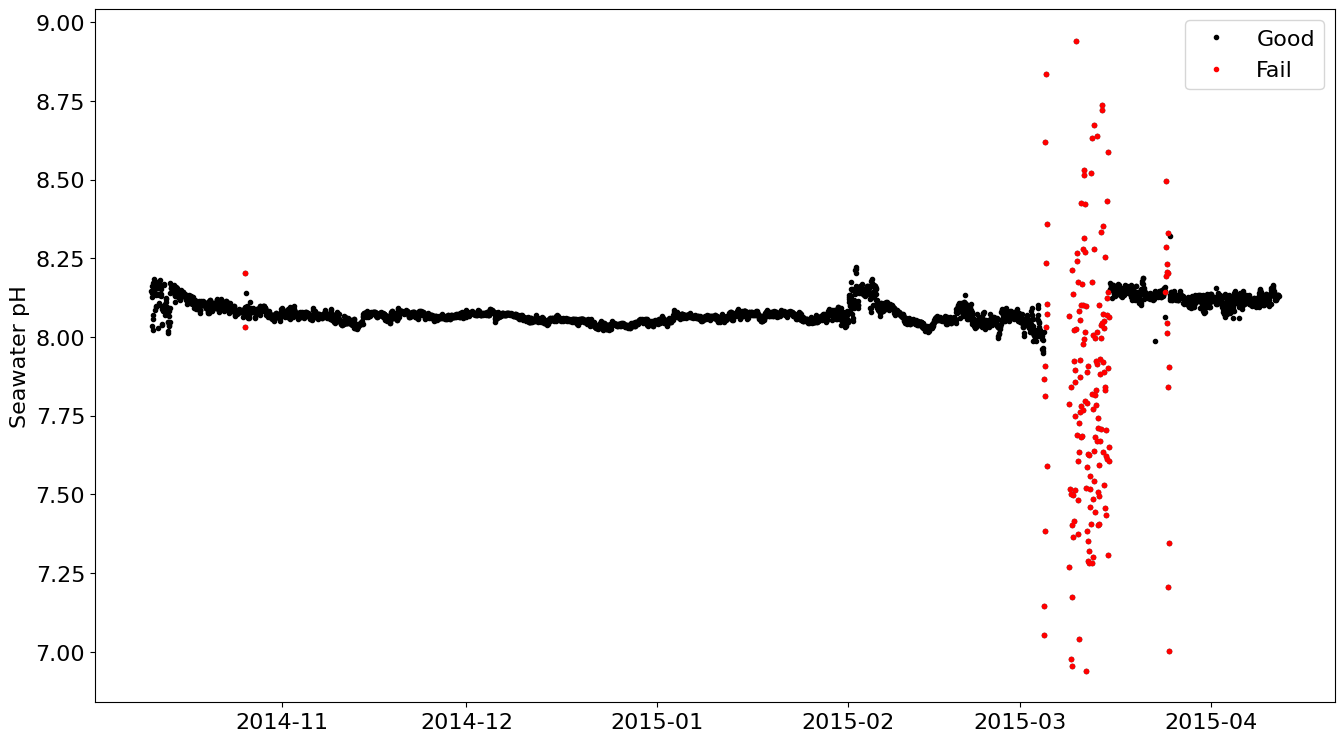

In [3]:
# plot the seawater pH values highlighting the "bad" data as defined by the quality checks
bad = phsen.where(phsen.seawater_ph_quality_flag==4)
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 16})
plt.plot(phsen['time'], phsen['seawater_ph'], '.k', label='Good')
plt.plot(bad['time'], bad['seawater_ph'], '.r', label='Fail')
plt.ylabel('Seawater pH')
plt.legend()

In [4]:
# create a boolean array of the quality flag for just the failed data
fail = phsen.seawater_ph_quality_flag.where(phsen.seawater_ph_quality_flag==4).notnull()

# identify blocks of failed data points
blocks = identify_blocks(fail, [24, 24])

# use the identified blocks of data marked as "fail" to create initial HITL annotations for the pH data
hitl = create_annotations(site, node, sensor, blocks)
hitl

{'id': [''],
 'subsite': ['CE01ISSM'],
 'node': ['RID16'],
 'sensor': ['06-PHSEND000'],
 'method': [None],
 'stream': [None],
 'parameters': [[]],
 'beginDT': [np.int64(1425501193000)],
 'beginDate': [np.str_('2015-03-04T20:33:13')],
 'endDT': [np.int64(1426419202000)],
 'endDate': [np.str_('2015-03-15T11:33:22')],
 'exclusionFlag': ['False'],
 'qcFlag': ['fail'],
 'source': ['replace.me@whatever.com'],
 'annotation': ['Based on a HITL review and automated quality assessments of the data, the data highlighted during this time period is considered inaccurate and users should avoid using the data as part of any analysis.']}

In [5]:
%%time
# set a regex tag to limit the data download to just the PHSEN data for all deployments
tag = '.*PHSEN.*\\.nc$'

# download the telemetered data and re-process it to create a more useful and coherent data set
telem = load_gc_thredds(site, node, sensor, 'telemetered', 'phsen_abcdef_dcl_instrument', tag)
telem = phsen_datalogger(telem)

# download the recovered host data and re-process it to create a more useful and coherent data set
rhost = load_gc_thredds(site, node, sensor, 'recovered_host', 'phsen_abcdef_dcl_instrument_recovered', tag)
rhost = phsen_datalogger(rhost)

# download the recovered instrument data and re-process it to create a more useful and coherent data set
rinst = load_gc_thredds(site, node, sensor, 'recovered_inst', 'phsen_abcdef_instrument', tag)
rinst = phsen_instrument(rinst)

# combine the three datasets into a single, merged time series, resampled to a 3 hour interval time series
merged = combine_datasets(telem, rhost, rinst, 180)
merged['seawater_ph'] = merged['seawater_ph'].where((merged['seawater_ph'] > 6.9) & (merged['seawater_ph'] < 9.0))

# re-run the quality checks, since averaging will change the flag values
merged['seawater_ph_quality_flag'] = quality_checks(merged)

Merging the data files into a single dataset
Merging the data files into a single dataset
Merging the data files into a single dataset
CPU times: user 1min 29s, sys: 1.98 s, total: 1min 31s
Wall time: 2min 14s


In [6]:
# Create the HITL annotations for the entire record and convert them into a pandas dataframe
fail = merged.seawater_ph_quality_flag.where(merged.seawater_ph_quality_flag==4).notnull()
blocks = identify_blocks(fail, [24, 24])
hitl = create_annotations(site, node, sensor, blocks)
hitl = pd.DataFrame(hitl)
hitl

,id,subsite,node,sensor,method,stream,parameters,beginDT,beginDate,endDT,endDate,exclusionFlag,qcFlag,source,annotation
0,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1397768400000,2014-04-17T21:00:00,1408222800000,2014-08-16T21:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
1,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1425502800000,2015-03-04T21:00:00,1426420800000,2015-03-15T12:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
2,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1488218400000,2017-02-27T18:00:00,1490605200000,2017-03-27T09:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
3,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1502150400000,2017-08-08T00:00:00,1502798400000,2017-08-15T12:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
4,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1503262800000,2017-08-20T21:00:00,1503414000000,2017-08-22T15:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
5,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1504504800000,2017-09-04T06:00:00,1507831200000,2017-10-12T18:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
6,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1512550800000,2017-12-06T09:00:00,1512864000000,2017-12-10T00:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
7,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1514300400000,2017-12-26T15:00:00,1522573200000,2018-04-01T09:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
8,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1547424000000,2019-01-14T00:00:00,1547899200000,2019-01-19T12:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
9,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1548201600000,2019-01-23T00:00:00,1548428400000,2019-01-25T15:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...


In [7]:
# get the current system annotations for the sensor
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
annotations = annotations.drop(columns=['@class'])
annotations['beginDate'] = pd.to_datetime(annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
annotations['endDate'] = pd.to_datetime(annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')

# append the fail annotations to the existing annotations
annotations = pd.concat([annotations, hitl], ignore_index=True)

# set the annotation column orders
header_names = ['id', 'subsite', 'node', 'sensor', 'method', 'stream', 'parameters', 
                'beginDT', 'beginDate', 'endDT', 'endDate', 'exclusionFlag', 'qcFlag', 'source', 'annotation']
annotations = annotations.reindex(columns=header_names)
annotations

,id,subsite,node,sensor,method,stream,parameters,beginDT,beginDate,endDT,endDate,exclusionFlag,qcFlag,source,annotation
0,1697,CE01ISSM,RID16,06-PHSEND000,None,None,[],1560643200000,2019-06-16T00:00:00,1.571789e+12,2019-10-22T23:57:00,False,suspect,wingardc@oregonstate.edu,Data indicates the sensor has either fouled or...
1,2342,CE01ISSM,None,None,recovered_host,None,[],1485949200000,2017-02-01T11:40:00,1.492458e+12,2017-04-17T19:45:00,False,not_operational,wingardc@oregonstate.edu,The buoy and mfn battery voltages have been dr...
2,1893,CE01ISSM,RID16,None,None,None,[],1578768300000,2020-01-11T18:45:00,1.594656e+12,2020-07-13T16:00:00,False,not_operational,wingardc@oregonstate.edu,"During a large storm event on 2020-01-11, the ..."
3,871,CE01ISSM,None,None,telemetered,None,[],1485949200000,2017-02-01T11:40:00,1.492458e+12,2017-04-17T19:45:00,False,not_operational,michaesm@marine.rutgers.edu,The buoy and mfn battery voltages have been dr...
4,868,CE01ISSM,None,None,telemetered,None,[],1397767500000,2014-04-17T20:45:00,1.408228e+12,2014-08-16T22:30:00,False,not_available,michaesm@marine.rutgers.edu,"Due to a bug in the mooring telemetry code, a ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1700265600000,2023-11-18T00:00:00,1.700838e+12,2023-11-24T15:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
62,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1701021600000,2023-11-26T18:00:00,1.702166e+12,2023-12-10T00:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
63,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1715245200000,2024-05-09T09:00:00,1.715591e+12,2024-05-13T09:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...
64,,CE01ISSM,RID16,06-PHSEND000,None,None,[],1724587200000,2024-08-25T12:00:00,1.724706e+12,2024-08-26T21:00:00,False,fail,replace.me@whatever.com,Based on a HITL review and automated quality a...


In [8]:
# use the annotation blocks created created above and merged with the existing system 
# annotations to create an annotation based QC flag.
merged = add_annotation_qc_flags(merged, annotations)

# create a "good" dataset excluding data marked as "fail" either from the quality checks or the annotations
good = merged.where((merged.seawater_ph_quality_flag != 4) & (merged.rollup_annotations_qc_results != 4))

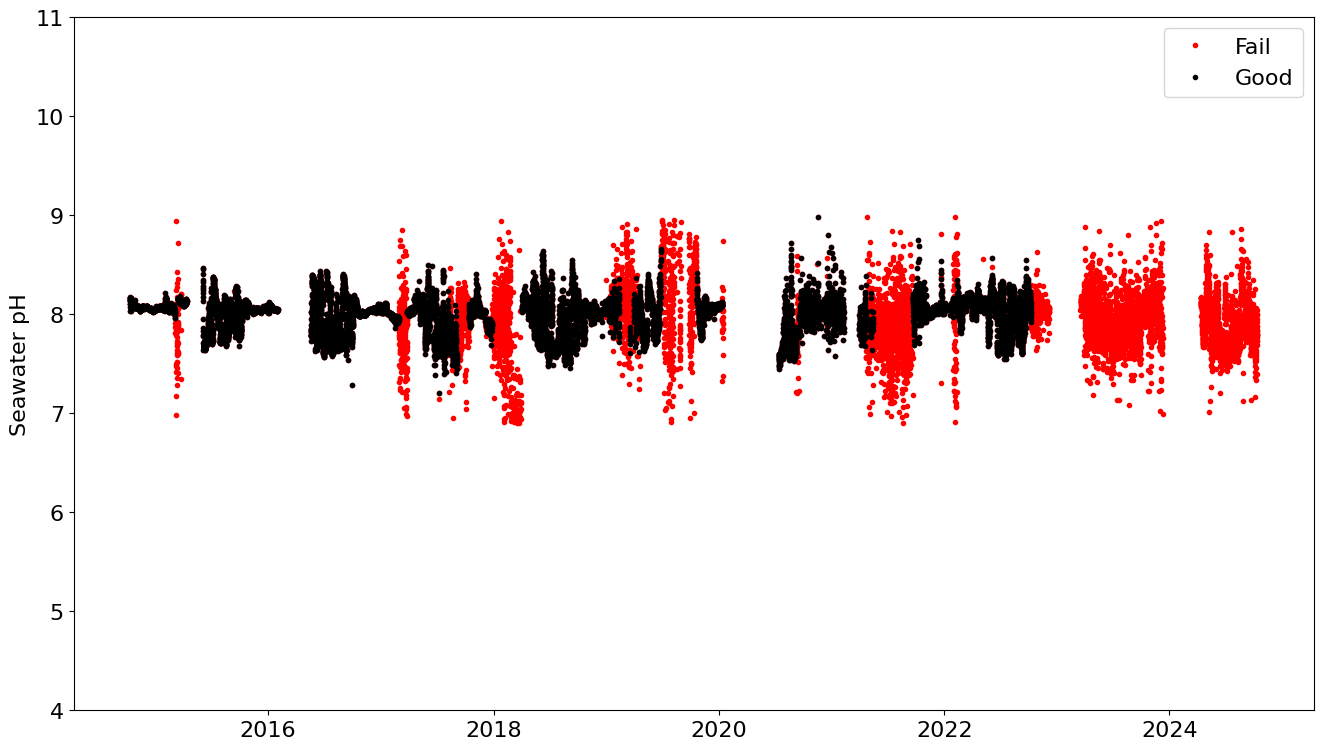

In [9]:
# plot the 6+ years of seawater pH values highlighting the "fail" data as defined by the quality checks
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 16})
plt.plot(merged['time'], merged['seawater_ph'], '.r', label='Fail')
plt.plot(good['time'], good['seawater_ph'], '.k', label='Good')
plt.ylabel('Seawater pH')
plt.ylim(4, 11)
plt.legend()

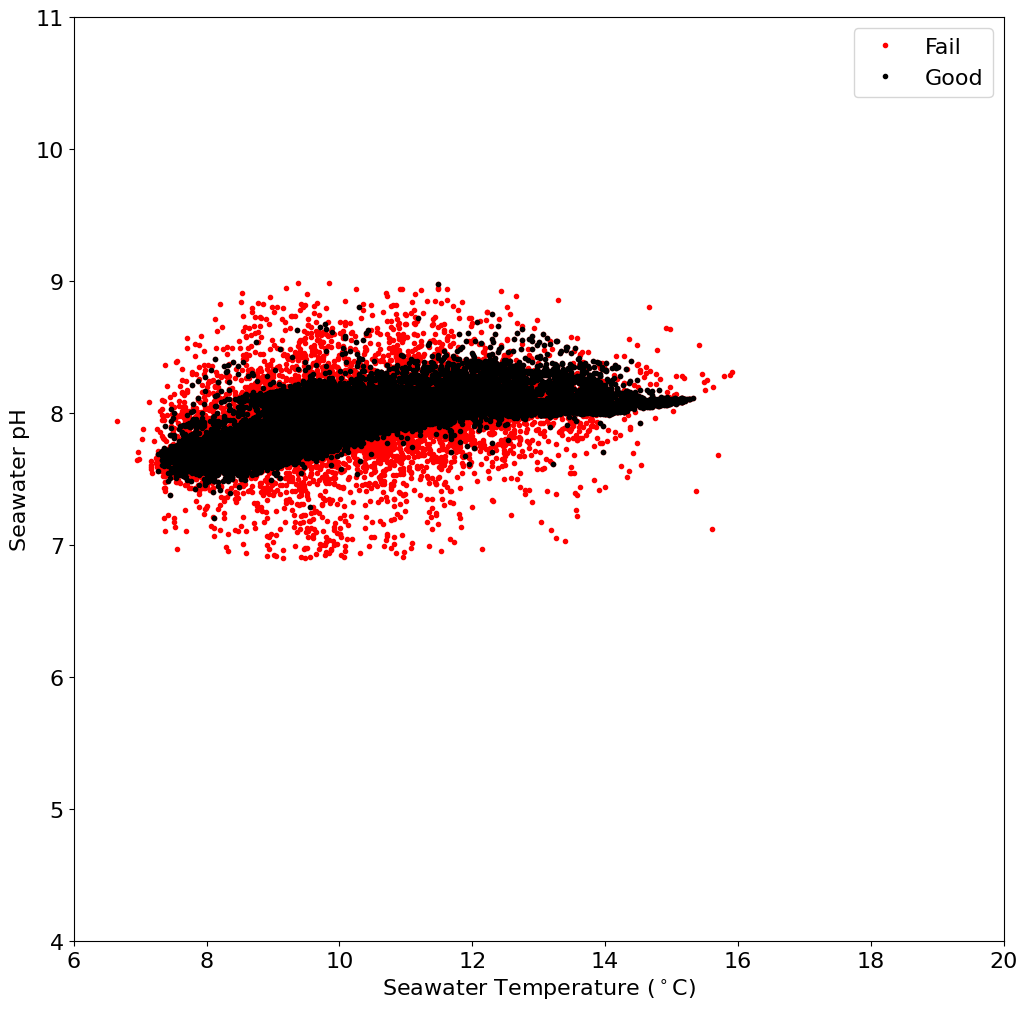

In [10]:
# plot the seawater pH as a function of temperature, again highlighting the "fail" data
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size': 16})
plt.plot(merged['thermistor_temperature'], merged['seawater_ph'], '.r', label='Fail')
plt.plot(good['thermistor_temperature'], good['seawater_ph'], '.k', label='Good')
plt.xlabel('Seawater Temperature ($^\circ$C)')
plt.ylabel('Seawater pH')
plt.ylim(4, 11)
plt.xlim(6, 20)
plt.legend()

(7.0, 9.0)

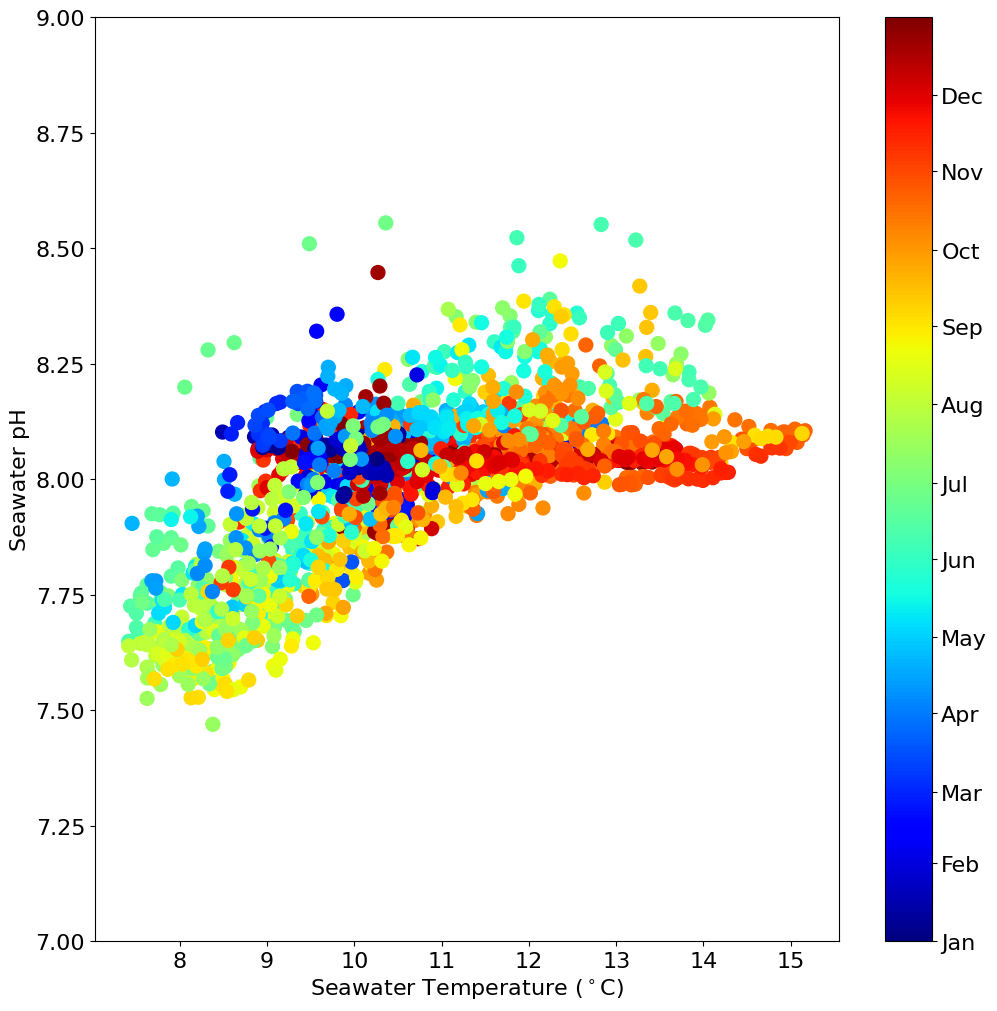

In [11]:
# plot the "good" seawater pH as a function of temperature, converted to daily, median averages.
# plus, let's see if we can tease out any seasonality to the temperature/pH relationship
daily = good.resample(time='D').median()
doy = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
cmnth = ['Jan', 'Feb', 'Mar', 'Apr', 
        'May', 'Jun', 'Jul', 'Aug',
        'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size': 16})
plt.scatter(daily['thermistor_temperature'], daily['seawater_ph'], c=daily['time'].dt.dayofyear, s=100, cmap='jet')
cbar = plt.colorbar()
cbar.set_ticks(doy)
cbar.set_ticklabels(cmnth)
plt.xlabel('Seawater Temperature ($^\circ$C)')
plt.ylabel('Seawater pH')
plt.ylim(7, 9)

In [12]:
# limit the time range and calculate the gross range values
good = good.sel(time=slice("2014-01-01T00:00:00", "2021-01-01T00:00:00"))
gr = process_gross_range(good, ['seawater_ph'], [6.9, 9.0], site=site, node=node, sensor=sensor)

Testing data for normality: seawater_ph
[########################################] | 100% Completed | 1.32 sms


In [13]:
print(gr.qcConfig.values)

[{'qartod': {'gross_range_test': {'suspect_span': [np.float64(7.4863), np.float64(8.56264)], 'fail_span': [6.9, 9.0]}}}]


In [14]:
# develop ranges for the QARTOD climatology test
clm, clm_table = process_climatology(good, ['seawater_ph'], [6.9, 9.0], site=site, node=node, sensor=sensor)

In [15]:
print(clm_table[0])

,"[1, 1]","[2, 2]","[3, 3]","[4, 4]","[5, 5]","[6, 6]","[7, 7]","[8, 8]","[9, 9]","[10, 10]","[11, 11]","[12, 12]"
"[0, 0]","[7.91743, 8.14042]","[7.79856, 8.24695]","[7.79968, 8.30575]","[7.77445, 8.37024]","[7.40135, 8.65953]","[7.18680, 8.67460]","[7.12786, 8.54873]","[7.22312, 8.42472]","[7.21518, 8.58274]","[7.71801, 8.29173]","[7.85751, 8.27712]","[7.85285, 8.27126]"


In [16]:
import datetime
from ooi_data_explorations.qartod.climatology import Climatology
clm = Climatology()
clm.fit(good['seawater_ph'])
clm.fitted_data.index = clm.fitted_data.index - datetime.timedelta(days=15)
clm.regression

{'beta': array([ 7.98610723, -0.09531616,  0.03374029,  0.04217056,  0.05249922,
         0.0242958 , -0.01679743,  0.00931113,  0.0118164 ]),
 'residuals': array([0.34604929]),
 'rank': np.int32(9),
 'singular_values': array([8.09951668, 6.40446115, 6.19376558, 5.75271583, 5.51420523,
        5.45714535, 5.16916117, 4.94454061, 4.53526533]),
 'variance_explained': array([0.58156015])}

In [17]:
std = np.append(clm.monthly_std.values[3:], clm.monthly_std.values)
std = np.append(std, clm.monthly_std.values)
std = np.append(std, clm.monthly_std.values)
std = np.append(std, clm.monthly_std.values) 
std = np.append(std, clm.monthly_std.values)
std = np.append(std, clm.monthly_std.values)
std = np.append(std, clm.monthly_std.values[:1])

(6.5, 9.5)

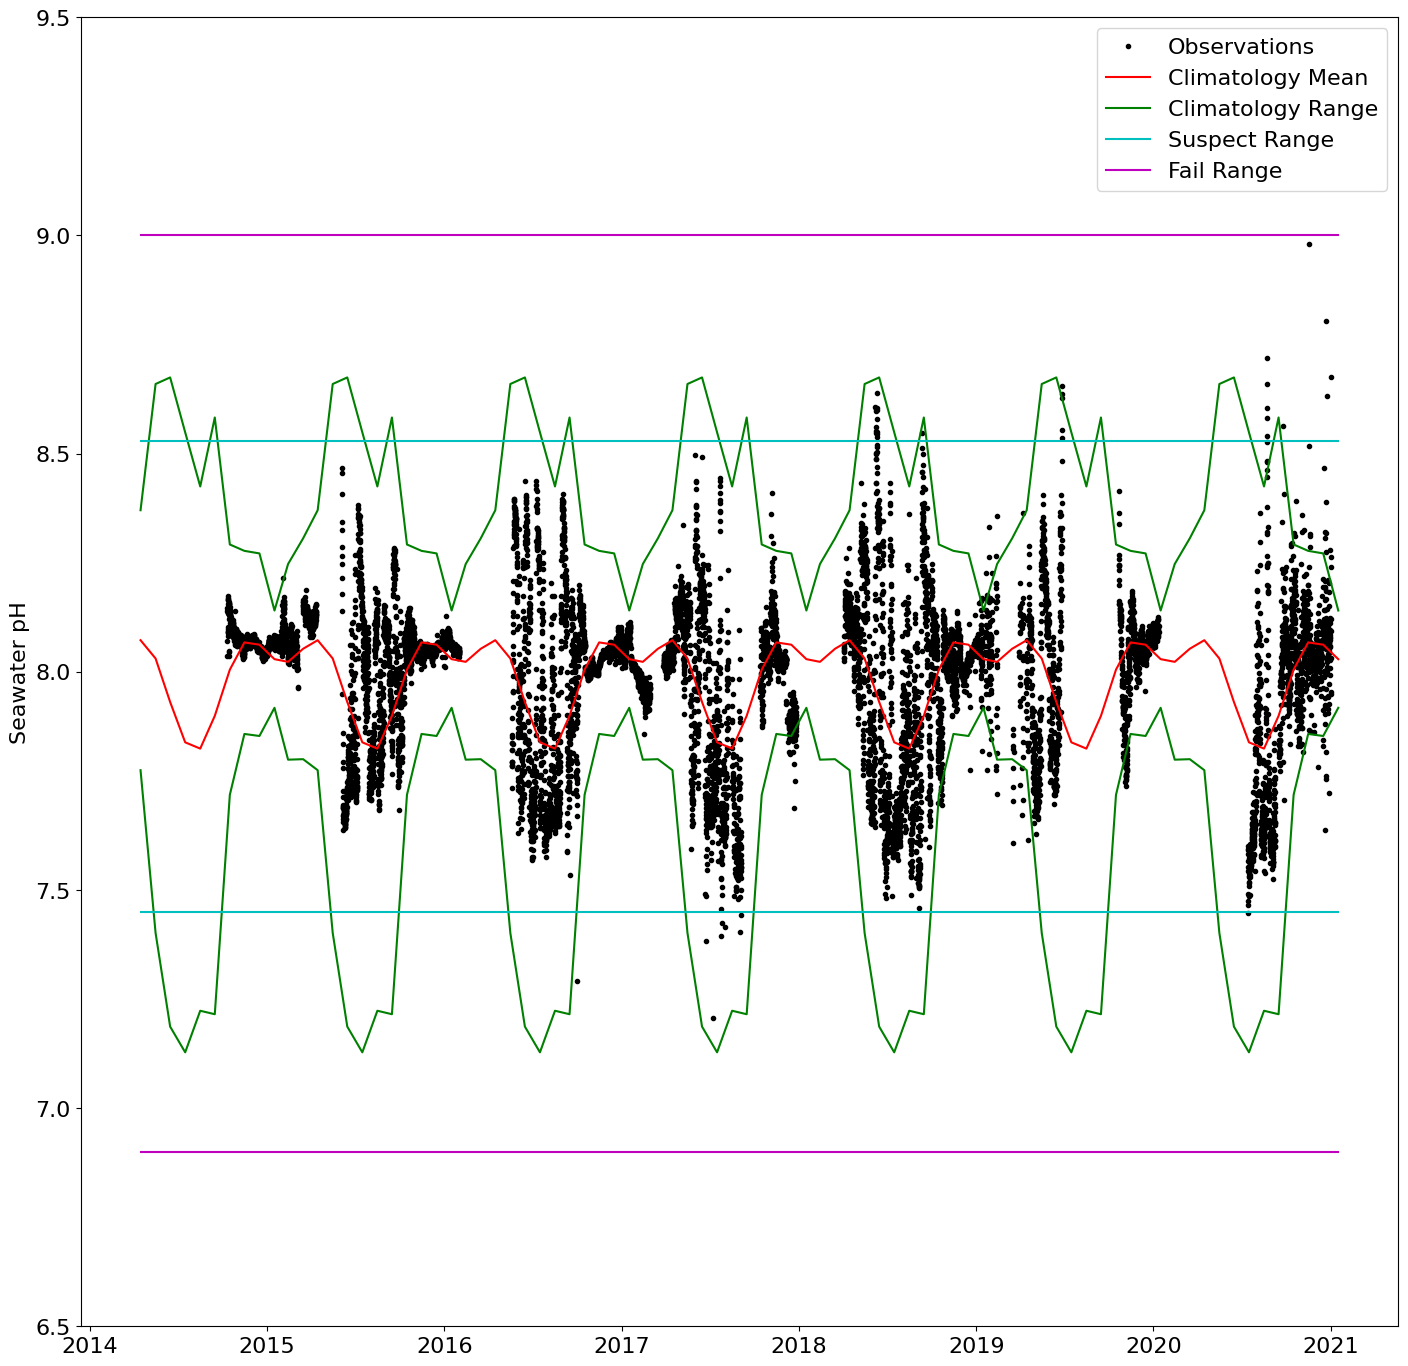

In [18]:
plt.figure(figsize=(17, 17))
plt.rcParams.update({'font.size': 16})
plt.plot(good['time'], good['seawater_ph'], '.k', label='Observations')
plt.plot(clm.fitted_data.index, clm.fitted_data.values, '-r', label='Climatology Mean')
plt.plot(clm.fitted_data.index, clm.fitted_data.values - 3 * std, '-g', label='Climatology Range')
plt.plot(clm.fitted_data.index, clm.fitted_data.values + 3 * std, '-g')
plt.plot(clm.fitted_data.index, np.repeat(7.45, 82), '-c', label='Suspect Range')
plt.plot(clm.fitted_data.index, np.repeat(8.53, 82), '-c')
plt.plot(clm.fitted_data.index, np.repeat(6.9, 82), '-m', label='Fail Range')
plt.plot(clm.fitted_data.index, np.repeat(9, 82), '-m')
plt.ylabel('Seawater pH')
plt.legend()
plt.ylim(6.5, 9.5)

In [19]:
# plot up the monthly means and the climatology fit to get a better understanding of the data and the 
# quality of the fit
mnthly = good.resample(time='M').mean()
grps = mnthly.groupby('time.month')

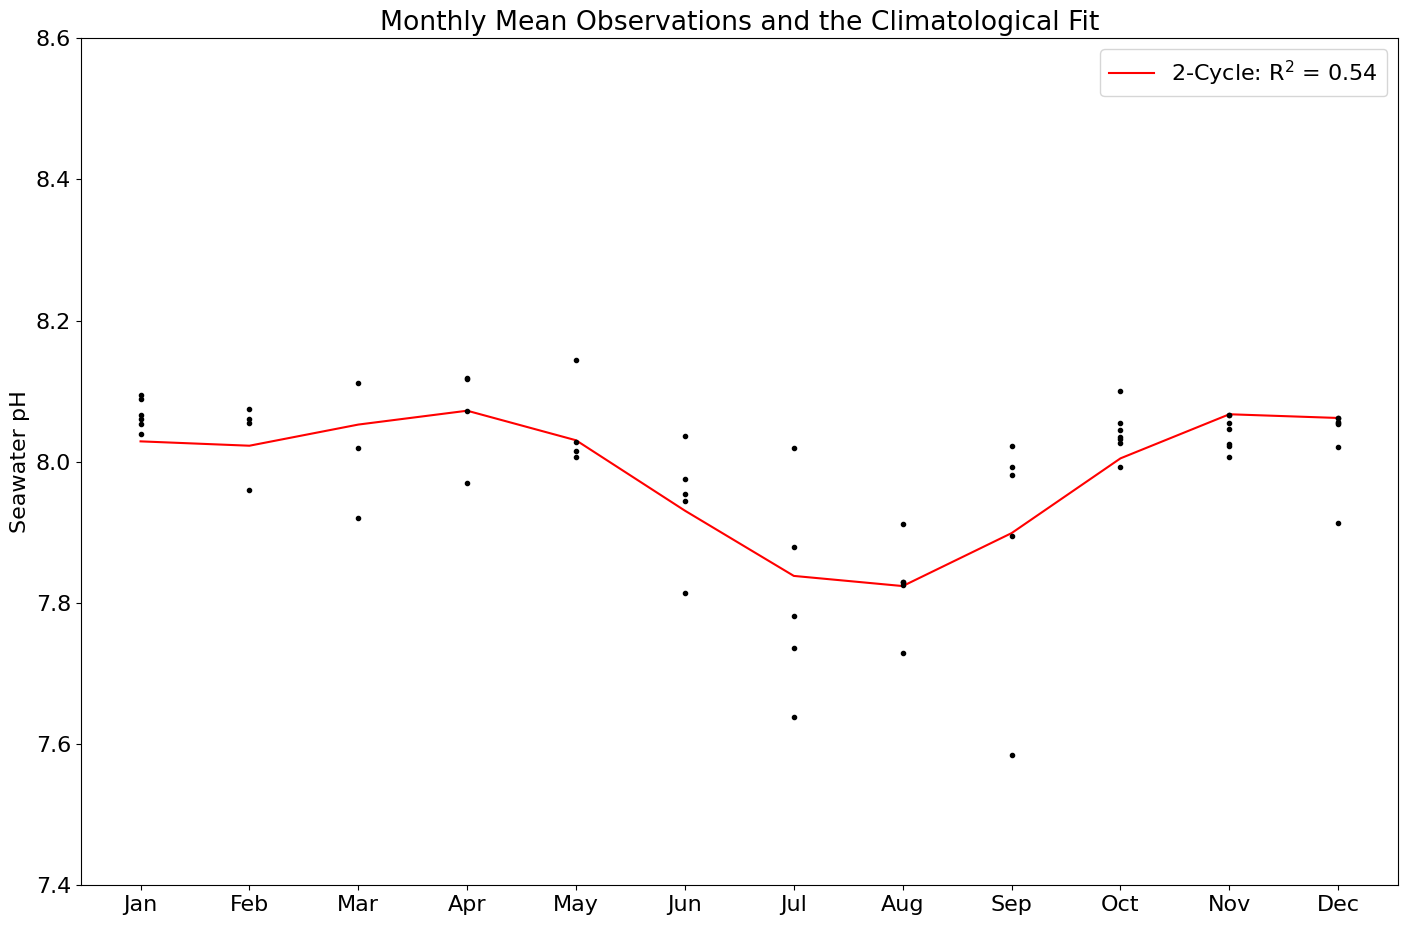

In [20]:
plt.figure(figsize=(17, 11))
plt.rcParams.update({'font.size': 16})
plt.plot(clm.monthly_fit.index, clm.monthly_fit.values, '-r', label='2-Cycle: R$^2$ = 0.54')
xtic = []
xlabel = []
for grp in grps:
    plt.plot(grp[1].time.to_index().strftime('%m').astype(int), grp[1]['seawater_ph'], '.k')
    xtic.append(grp[1].time.to_index().strftime('%m').astype(int)[0])
    xlabel.append(grp[1].time.to_index().strftime('%b')[0])
plt.title('Monthly Mean Observations and the Climatological Fit')
plt.ylabel('Seawater pH')
plt.xticks(xtic, xlabel)
plt.ylim(7.4, 8.6)
plt.legend()